**This Jupyter notebook contains data visualization source code used in the paper V. Ramaglia et al. *Multiplexed imaging of immune cells in staged multiple sclerosis lesions by mass cytometry*, 2019 (under review).**

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import re
from functools import partial

## Load data

In [2]:
cells = pd.read_csv("data/AllCells.csv")

In [3]:
# Clean up the rough class names that were used for manual annotation
cells["Assigned Class"] = cells["Assigned Class"].replace({
    "Manual T cell": "Manual T Cells",
    "Manual TC cell": "Manual CD8α+ T Cells",
    "Manual TH Cell": "Manual CD4+ T Cells",
    "Manual TC Prolif Cell": "Manual Prolif. CD8α+ T Cells",
    "Manual TH Prolif Cell": "Manual Prolif. CD4+ T Cells",
    "Manual Act Macrophage": "Manual Act. Microglia",
    "Manual Activated Microglia": "Manual Act. Microglia",
    "Manual Macrophage": "Manual Macrophages",
    "Manual Act Macrophage": "Manual Act. Macrophages",
    "Manual A-P-DeMyel MicroGlia": "Manual A-P-DeMyel Microglia",
    "Manual B cell IgL": "Manual B Cells", 
    "Manual B cell IgK": "Manual B Cells",
    "Manual IgK Naive": "Manual Naive B Cells",
    "Manual IgL Naive": "Manual Naive B Cells",
    "Manual B Cell Switched": "Manual Switched Memory B Cells",
    "Manual B Cell Naive": "Manual Naive B Cells",
    "Manual IgK Switched Memory": "Manual Switched Memory B Cells", 
    "Manual IgL Switched Memory": "Manual Switched Memory B Cells",
    "Manual IgL IgM Memory": "Manual IgM+ Memory B Cells",
    "Manual IgK IgM Memory": "Manual IgM+ Memory B Cells",
    "Manual B cell": "Manual B Cells",
    "Manual Myeloid": "Manual Myeloid Cells",
    "Endothelial Cell": "Manual Endothelial Cells",
    "Manual Endothelial Cell": "Manual Endothelial Cells"
})

In [4]:
# Merge ROI mapping into main dataframe
# This intentionally excludes all undefined image/subROI combinations (not all cells are relevant)
rois = pd.melt(pd.read_csv("data/ImageROIs.csv"), id_vars="Image Name", var_name="SubROI", value_name="ROI").dropna()
df = cells.merge(rois, how="inner", on=["Image Name", "SubROI"])

In [5]:
# Frequency table of assigned classes for cells
pd.crosstab(df["Assigned Class"], df["ROI"], margins=True)

ROI,Active Core,Active Periplaque,NAWM,Preactive,SEL Core,SEL Edge,SEL Periplaque,WMC,All
Assigned Class,,,,,,,,,
Manual A-P-DeMyel Macrophages,29,1,3,2,11,20,0,0,66
Manual A-P-DeMyel Microglia,15,2,0,6,7,14,4,0,48
Manual Act. Macrophages,40,0,4,5,6,24,1,0,80
Manual Act. Microglia,34,0,12,6,4,21,3,0,80
Manual B Cells,84,1,2,11,26,37,7,0,168
Manual CD4+ T Cells,150,2,9,31,28,33,23,0,276
Manual CD8α+ T Cells,254,17,10,53,74,67,68,0,543
Manual Endothelial Cells,68,7,17,15,56,41,35,0,239
Manual IgM+ Memory B Cells,1,0,0,0,1,0,3,0,5


## Normalize cell intensities

This step is a linear scaling of the intensity data for purely visual purposes, so that the axes limits are consistent across different markers.

In [6]:
def normalize(col, pct=0.99):
    high_th = col.quantile(pct)
    low_th = col.min()
    out = (col - low_th)/(high_th - low_th)
    return out, low_th, high_th

In [7]:
intensity_cols = list(df.filter(regex="Mean (?!Norm)").columns)
scale_factors = {}

for col in intensity_cols:
    marker = ''.join(col[5:].split("_")[:-1])
    df[f"Mean Norm_{marker}"], low, hi = normalize(df[col])
    scale_factors[marker] = (low, hi)

print(tuple(scale_factors.keys()))  # Markers of interest with conjugated metals removed for brevity

('CD38', 'CD3', 'CD45', 'CD4', 'CD68', 'CD8a', 'Collagen', 'DNA', 'HLA', 'IgKappa', 'IgLambda', 'IgM', 'Ki67', 'NFAT1', 'PLP', 'TMEM119')


## Plot manual annotations (Figure 7 - Supplement 2)

In [8]:
sns.set(style="ticks")
sns.set_context("notebook", font_scale=1.5)

In [9]:
# Gates (determined with help of experts after inspecting manual plots)
GATE = {
    "CD3": 0.2,
    "CD38": 0.3,
    "CD45": None,
    "CD45_T": 0.18, # For T only
    "CD45_B": 0.045, # For B only
    "CD8a": 0.25,
    "CD4": 0.25,
    "CD68": 0.04,
    "IgKappa": 0.5,
    "IgLambda": 0.7,
    "IgM": 0.3,
    "NFAT1": 0.12,
    "Ki67": 0.5,
    "HLA": 0.06,
    "TMEM119": 0.5,
    "PLP": 0.01,
}

# Boolean selectors on df for +/- markers (for convenience)
LO = {}
HI = {}
for marker, gate in GATE.items():
    if "_" not in marker:
        LO[marker] = df[f"Mean Norm_{marker}"] < gate
        HI[marker] = df[f"Mean Norm_{marker}"] >= gate
    else:  # e.g. Consider "CD45_T" as assessing the "Mean Norm CD45" values
        LO[marker] = df[f"Mean Norm_{marker.split('_')[0]}"] < gate
        HI[marker] = df[f"Mean Norm_{marker.split('_')[0]}"] >= gate

In [10]:
def plot_gates(df, classes, x, y, gate_x=None, gate_y=None, 
               pal=None, remove_first=False, savefig=False):
    """
    Plotting function for creating biaxial log/log scatterplots with gates.
    Note GATE, HI, and LO (global variables) are referenced here.
    """
    
    # Generate dynamic colour palette if not specified
    if pal is None:
        pal = sns.color_palette("husl", len(classes))
    # Always draw Nucleus in white if present - these are unclassified "background" cells for context
    if classes[0] == "Nucleus":
        pal = sns.color_palette("husl", max(len(classes)-1, 1))
        pal = np.concatenate([np.array([[1,1,1]]), pal])
        remove_first = True
    cat_colors = {clss: c for c, clss in zip(pal, classes)}
    
    # Initialize figure/axis settings
    f, ax = plt.subplots(figsize=(8, 8))
    ax.set(xscale="log", yscale="log")
    ax.set_xlim(5e-4, 3)
    ax.set_ylim(5e-4, 3)
    ax.set_aspect(aspect="equal")
    ax.set_xlabel(f"Mean {x}")
    ax.set_ylabel(f"Mean {y}")
    
    # Substitute Greek letters in labels
    if x == "CD8a": ax.set_xlabel(f"Mean CD8α")
    if x == "IgKappa": ax.set_xlabel(f"Mean Igκ")
    if x == "IgLambda": ax.set_xlabel(f"Mean Igλ")
    if y == "CD8a": ax.set_ylabel(f"Mean CD8α")
    if y == "IgKappa": ax.set_ylabel(f"Mean Igκ")
    if y == "IgLambda": ax.set_ylabel(f"Mean Igλ")
    
    for i, clss in enumerate(cat_colors):
        if clss not in df["Assigned Class"].values: continue
        alpha = 1. if clss != "Nucleus" else 0.75
        label = None if remove_first and i == 0 else clss
        ax.scatter(
            df[df["Assigned Class"] == clss][f"Mean Norm_{x}"], 
            df[df["Assigned Class"] == clss][f"Mean Norm_{y}"],
            c=np.array([cat_colors[clss]]), marker='o', edgecolor='k', linewidths=0.1,
            s=20, label=label, alpha=alpha
        )

    # Draw gate lines
    gate_x = gate_x if gate_x is not None else x
    gate_y = gate_y if gate_y is not None else y
    ax.axvline(x=GATE[gate_x], color='r', linestyle='--', linewidth=3)
    ax.axhline(y=GATE[gate_y], color='g', linestyle='--', linewidth=3)

    # Add text to 4 quadrants with %s of each cell class
    text_kwargs = {"transform": ax.transAxes, "verticalalignment": "center", "horizontalalignment": "left"}
    classes = classes[1:] if classes[0] == "Nucleus" else classes
    for i, clss in enumerate(classes):
        # Compute number of cells in each quadrant
        total = len(df[(df["Assigned Class"] == clss)])
        ur = df[(df["Assigned Class"] == clss) & HI[gate_x] & HI[gate_y]].shape[0]
        lr = df[(df["Assigned Class"] == clss) & HI[gate_x] & LO[gate_y]].shape[0]
        ll = df[(df["Assigned Class"] == clss) & LO[gate_x] & LO[gate_y]].shape[0]
        ul = df[(df["Assigned Class"] == clss) & LO[gate_x] & HI[gate_y]].shape[0]
        # Transformation from log scale data coordinates (gate) to axis coordinates
        ygateax = (ax.transScale + ax.transLimits).transform((GATE[gate_x], GATE[gate_y]))
        ax.text(x=1.01, y=0.97 - i*0.045, s=f"{ur/total*100.:0.1f}%", color=cat_colors[clss], **text_kwargs)
        ax.text(x=1.01, y=ygateax[1] - 0.04 - i*0.045, s=f"{lr/total*100.:0.1f}%", color=cat_colors[clss], **text_kwargs)
        ax.text(x=0.01, y=ygateax[1] - 0.04 - i*0.045, s=f"{ll/total*100.:0.1f}%", color=cat_colors[clss], **text_kwargs)
        ax.text(x=0.01, y=0.97 - i*0.045, s=f"{ul/total*100.:0.1f}%", color=cat_colors[clss], **text_kwargs)
    
    # Include legend
    ax.legend(loc="lower left", fontsize="small")
    if savefig:
        f.savefig(f"{'_'.join(classes)}_x{x}_y{y}.png", dpi=300, bbox_inches="tight")

In [11]:
# Create mappings of class names to subclasses
# e.g. all Macrophage and Microglia are Myeloid cells -> sometimes we want to plot them individually but other times we lump them together (df.replace)

def lump(pattern, out_class, classes, prefix=""):
    """Convenience function for creating many-to-one replacement dictionaries to lump togther classes."""
    return {f"{prefix}{clss}": f"{prefix}{out_class}" 
            for clss in classes if re.search(pattern, clss) is not None and clss != out_class}

manual_classes = [clss[7:] for clss in cells["Assigned Class"].unique()]
lump_manual = partial(lump, prefix="Manual ", classes=manual_classes)

LUMP_MYELOID = lump_manual("Macrophages$|Microglia$", "Myeloid Cells")
LUMP_MACROPHAGE = lump_manual("Macrophages$", "Macrophages")
LUMP_MICROGLIA = lump_manual("Microglia$", "Microglia")
LUMP_ACT_MYELOID = {"A-P-DeMyel Microglia": "Manual Act Microglia",
                    "A-P-DeMyel Macrophage": "Manual Act Macrophage"}
LUMP_B_CELLS = lump_manual("B Cells$", "B Cells")
LUMP_T_CELLS = lump_manual("T Cells$", "T Cells")
LUMP_T_CELLS_CD8 = lump_manual("CD8\α\+ T Cells$", "CD8α+ T Cells")
LUMP_T_CELLS_CD4 = lump_manual("CD4\+ T Cells$", "CD4+ T Cells")

### T Cell Markers

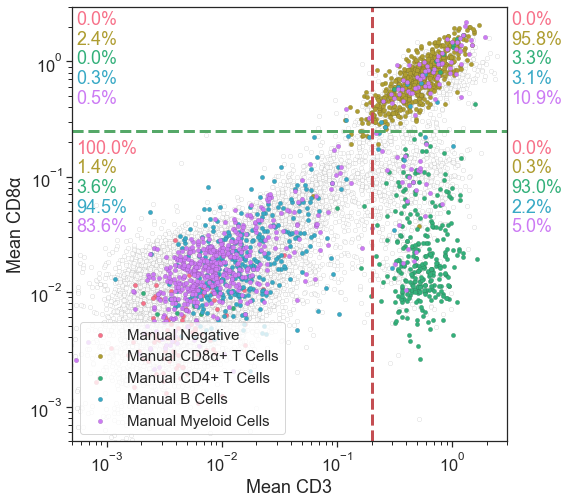

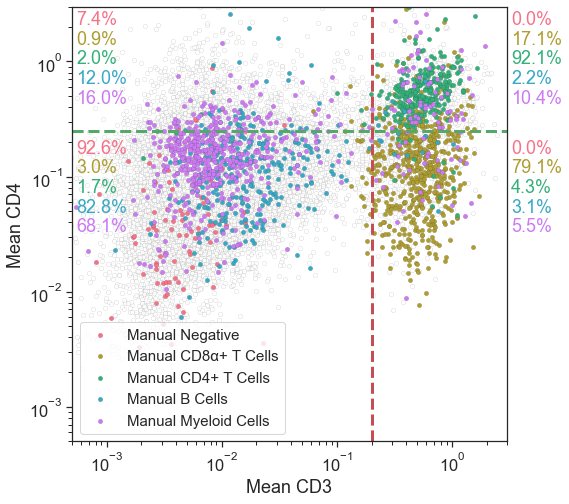

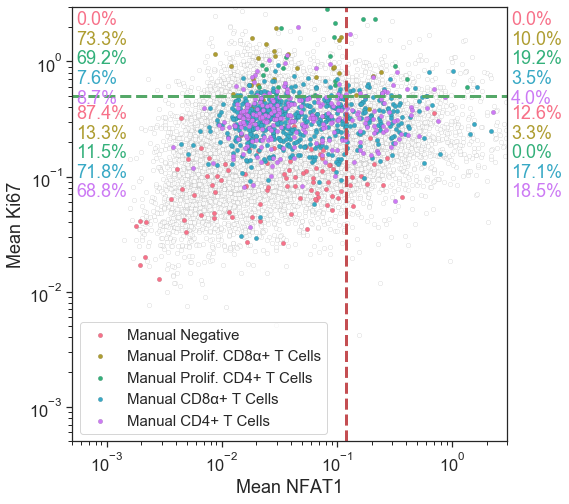

In [12]:
plot_gates(df.replace(LUMP_T_CELLS_CD8).replace(LUMP_T_CELLS_CD4).replace(LUMP_B_CELLS).replace(LUMP_MYELOID),
           ["Nucleus", "Manual Negative", "Manual CD8α+ T Cells", "Manual CD4+ T Cells", "Manual B Cells", "Manual Myeloid Cells"],
           "CD3", "CD8a")

plot_gates(df.replace(LUMP_T_CELLS_CD8).replace(LUMP_T_CELLS_CD4).replace(LUMP_B_CELLS).replace(LUMP_MYELOID),
           ["Nucleus", "Manual Negative", "Manual CD8α+ T Cells", "Manual CD4+ T Cells", "Manual B Cells", "Manual Myeloid Cells"],
           "CD3", "CD4")

plot_gates(df, 
           ["Nucleus", "Manual Negative", "Manual Prolif. CD8α+ T Cells", "Manual Prolif. CD4+ T Cells", "Manual CD8α+ T Cells", "Manual CD4+ T Cells"], 
           "NFAT1", "Ki67")

### B Cell Markers

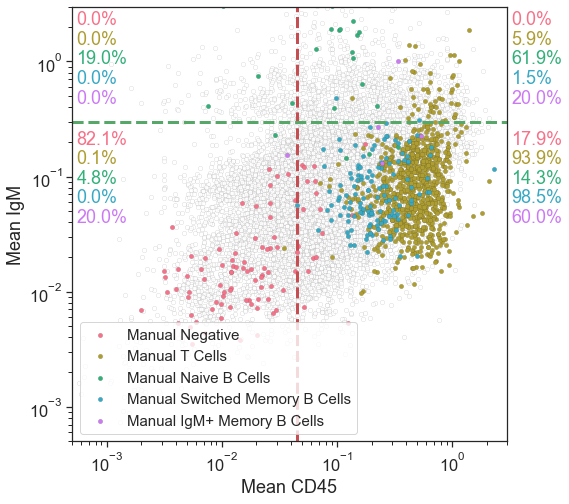

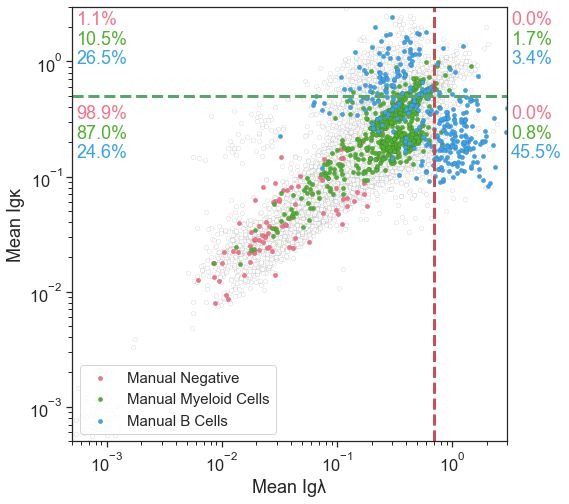

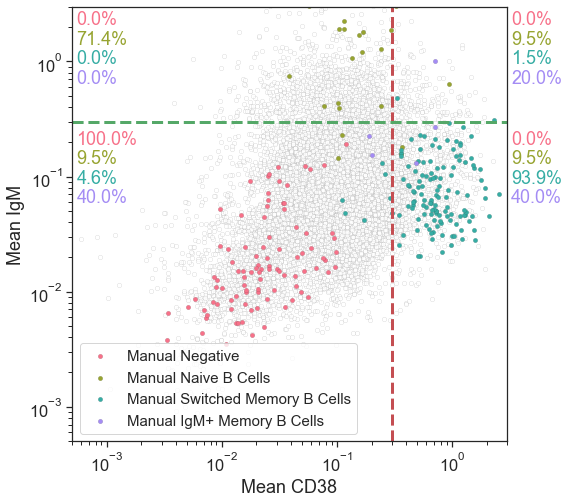

In [13]:
plot_gates(df.replace(LUMP_T_CELLS),
           ["Nucleus", "Manual Negative", "Manual T Cells", "Manual Naive B Cells", "Manual Switched Memory B Cells", "Manual IgM+ Memory B Cells"],
           "CD45", "IgM", gate_x="CD45_B")

plot_gates(df.replace(LUMP_T_CELLS).replace(LUMP_B_CELLS).replace(LUMP_MYELOID), 
           ["Nucleus", "Manual Negative", "Manual Myeloid Cells", "Manual B Cells"],
           "IgLambda", "IgKappa")

plot_gates(df, 
           ["Nucleus", "Manual Negative", "Manual Naive B Cells", "Manual Switched Memory B Cells", "Manual IgM+ Memory B Cells"],
           "CD38", "IgM")

### Myeloid Markers

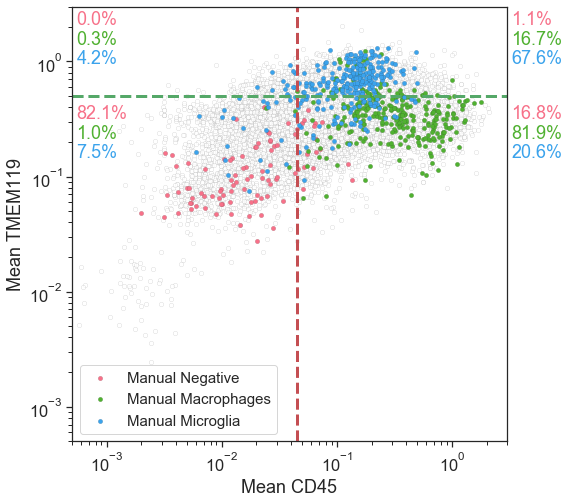

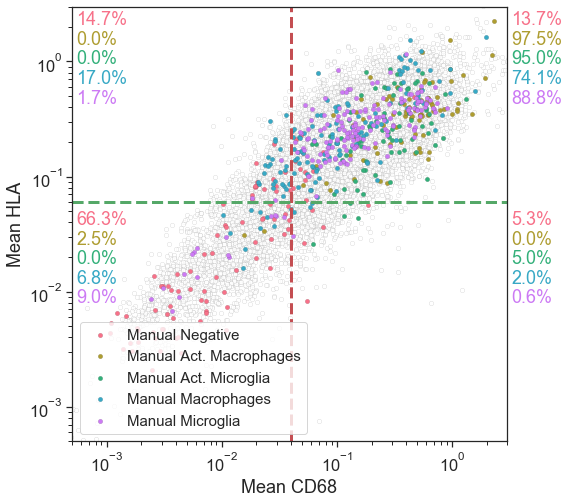

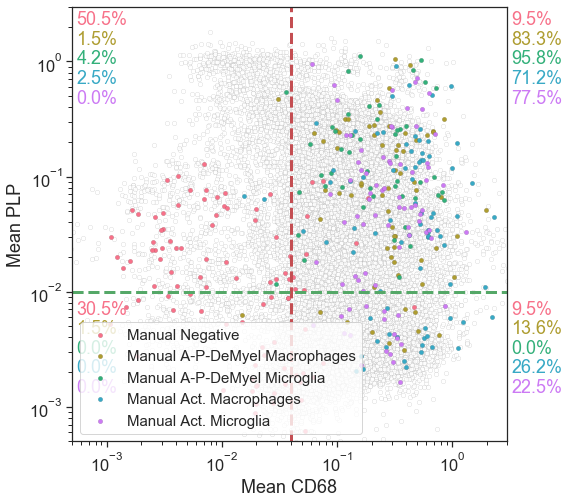

In [14]:
plot_gates(df.replace(LUMP_MACROPHAGE).replace(LUMP_MICROGLIA), 
           ["Nucleus", "Manual Negative", "Manual Macrophages", "Manual Microglia"],
           "CD45", "TMEM119", gate_x="CD45_B")

plot_gates(df.replace(LUMP_ACT_MYELOID), 
           ["Nucleus", "Manual Negative", "Manual Act. Macrophages", "Manual Act. Microglia", "Manual Macrophages", "Manual Microglia"],
           "CD68", "HLA")

plot_gates(df, 
           ["Nucleus", "Manual Negative", "Manual A-P-DeMyel Macrophages", "Manual A-P-DeMyel Microglia", "Manual Act. Macrophages", "Manual Act. Microglia"],
           "CD68", "PLP")

## Apply gates to all cells (Figure 7 - Supplement 3)
### Classify Myeloid Cells 

In [15]:
df.loc[:, "Assigned Class"] = "Nucleus"  # Reset all to nucleus

negative_cond = LO["CD3"] & LO["CD4"] & LO["IgM"] & LO["IgKappa"] & LO["IgLambda"]
df.loc[negative_cond, "Assigned Class"] = "CD3- CD4- IgM- λ- κ-"
df.loc[negative_cond & HI["CD45_T"] & LO["TMEM119"], "Assigned Class"] = "Macrophages"
df.loc[negative_cond & HI["TMEM119"], "Assigned Class"] = "Microglia"

df.loc[negative_cond & HI["CD45_T"] & LO["TMEM119"] & LO["CD68"], "Assigned Class"] = "Resting Macrophages"
df.loc[negative_cond & HI["TMEM119"] & LO["CD68"], "Assigned Class"] = "Resting Microglia"

df.loc[negative_cond & HI["CD45_T"] & LO["TMEM119"] & HI["HLA"] & HI["CD68"] & LO["PLP"], "Assigned Class"] = "Active ND Macrophages"
df.loc[negative_cond & HI["CD45_T"] & LO["TMEM119"] & HI["HLA"] & HI["CD68"] & HI["PLP"], "Assigned Class"] = "Active D Macrophages"
df.loc[negative_cond & HI["TMEM119"] & HI["HLA"] & HI["CD68"] & LO["PLP"], "Assigned Class"] = "Active ND Microglia"
df.loc[negative_cond & HI["TMEM119"] & HI["HLA"] & HI["CD68"] & HI["PLP"], "Assigned Class"] = "Active D Microglia"

myeloid_data = df.filter(regex="(Assigned Class|Mean Norm.*)")

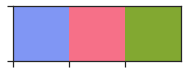

In [16]:
# Specify a manual colour palette to keep colours consistent in these plots
base = sns.color_palette("husl", 7)
myeloid_pal = [base[5], base[0], base[2]]
sns.palplot(myeloid_pal)

In [17]:
lump_myeloid = partial(lump, classes=myeloid_data["Assigned Class"].unique())

LUMP_MACROPHAGES = lump_myeloid("Macrophages$", "Macrophages")
LUMP_MICROGLIA = lump_myeloid("Microglia$", "Microglia")

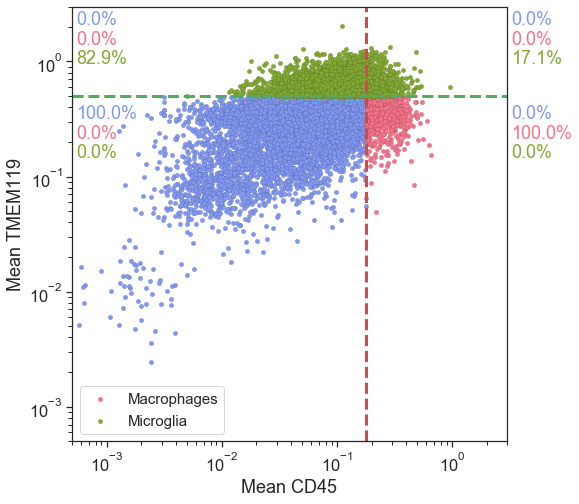

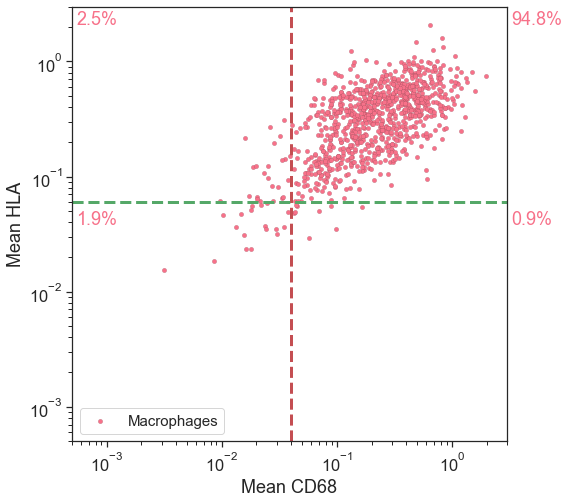

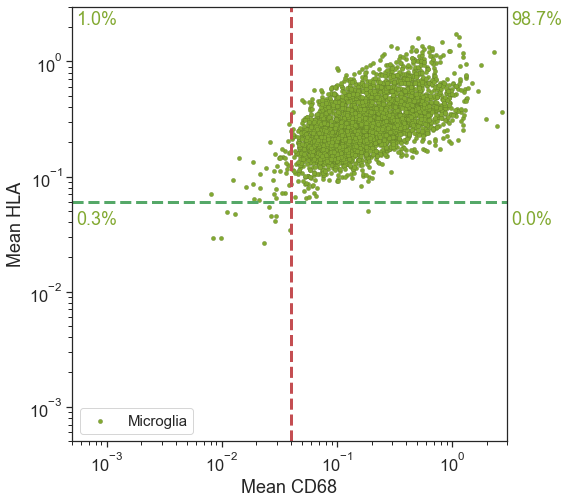

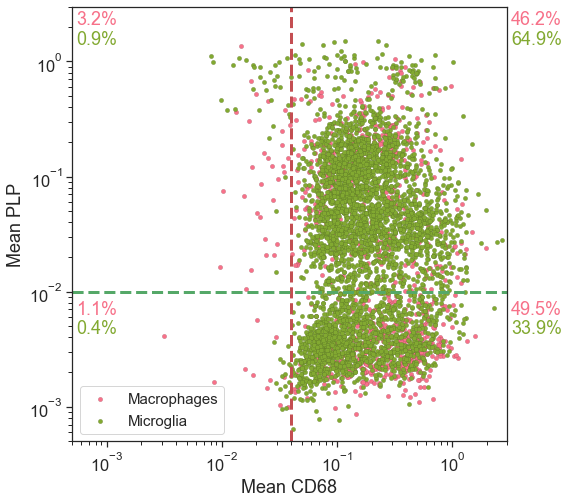

In [18]:
plot_gates(myeloid_data.replace(LUMP_MACROPHAGES).replace(LUMP_MICROGLIA), 
           ["CD3- CD4- IgM- λ- κ-", "Macrophages", "Microglia"],
           "CD45", "TMEM119", gate_x="CD45_T", pal=myeloid_pal, remove_first=True)

plot_gates(myeloid_data.replace(LUMP_MACROPHAGES), 
           ["Macrophages"],
           "CD68", "HLA", pal=[myeloid_pal[1]])

plot_gates(myeloid_data.replace(LUMP_MICROGLIA),
           ["Microglia"],
           "CD68", "HLA", pal=[myeloid_pal[2]])

plot_gates(myeloid_data.replace(LUMP_MACROPHAGES).replace(LUMP_MICROGLIA), 
           ["Macrophages", "Microglia"],
           "CD68", "PLP", pal=myeloid_pal[1:])

### Classify T Cells

In [19]:
df.loc[:, "Assigned Class"] = "Nucleus"  # Reset all to nucleus

negative_cond = LO["IgKappa"] & LO["IgLambda"] & LO["IgM"] & HI["CD45_T"]
df.loc[negative_cond, "Assigned Class"] = "IgM- λ- κ- CD45+"
df.loc[negative_cond & HI["CD3"] & HI["CD45_T"], "Assigned Class"] = "Unclassified T Cells"
df.loc[negative_cond & HI["CD3"] & HI["CD45_T"] & HI["CD8a"] & LO["CD4"] , "Assigned Class"] = "CD8α+ T Cells"
df.loc[negative_cond & HI["CD3"] & HI["CD45_T"] & LO["CD8a"] & HI["CD4"] , "Assigned Class"] = "CD4+ T Cells"

df.loc[negative_cond & HI["CD3"] & HI["CD45_T"] & HI["CD8a"] & LO["CD4"] & HI["Ki67"], "Assigned Class"] = "Proliferating CD8α+"
df.loc[negative_cond & HI["CD3"] & HI["CD45_T"] & LO["CD8a"] & HI["CD4"] & HI["Ki67"], "Assigned Class"] = "Proliferating CD4+"

df.loc[negative_cond & HI["CD3"] & HI["CD45_T"] & HI["CD8a"] & LO["CD4"] & HI["NFAT1"], "Assigned Class"] = "Activated CD8α+"
df.loc[negative_cond & HI["CD3"] & HI["CD45_T"] & LO["CD8a"] & HI["CD4"] & HI["NFAT1"], "Assigned Class"] = "Activated CD4+"

df.loc[negative_cond & HI["CD3"] & HI["CD45_T"] & HI["CD8a"] & LO["CD4"] & HI["Ki67"] & HI["NFAT1"], "Assigned Class"] = "Prolif. & Activ. CD8α+"
df.loc[negative_cond & HI["CD3"] & HI["CD45_T"] & LO["CD8a"] & HI["CD4"] & HI["Ki67"] & HI["NFAT1"], "Assigned Class"] = "Prolif. & Activ. CD4+"

tcell_data = df.filter(regex="(Assigned Class|Mean Norm.*)")

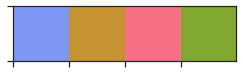

In [20]:
t_pal = [base[5], base[1], base[0], base[2]]
sns.palplot(t_pal)

In [21]:
lump_tcell = partial(lump, classes=tcell_data["Assigned Class"].unique())

LUMP_T_CD4 = lump_tcell("CD4\+", "CD4+ T Cells")
LUMP_T_CD8 = lump_tcell("CD8\α\+", "CD8α+ T Cells")

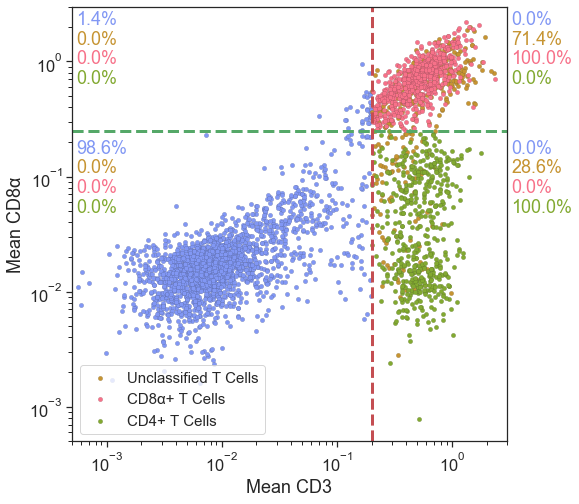

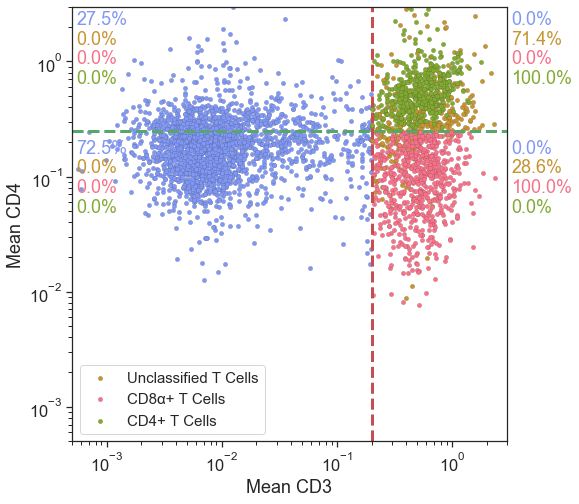

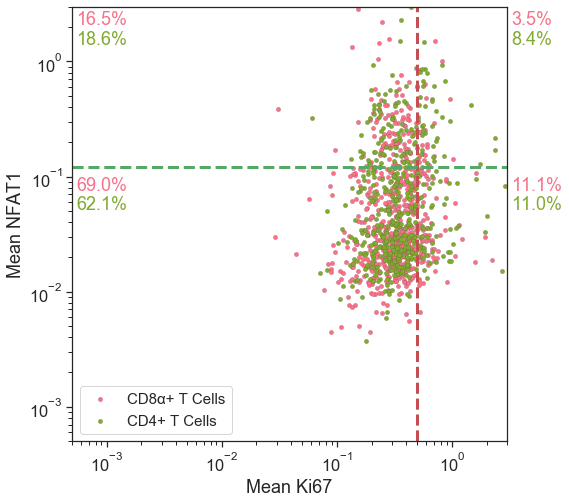

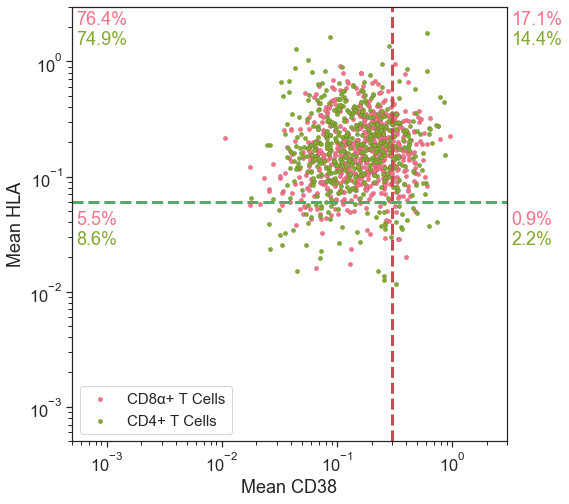

In [22]:
plot_gates(tcell_data.replace(LUMP_T_CD4).replace(LUMP_T_CD8), 
           ["IgM- λ- κ- CD45+", "Unclassified T Cells", "CD8α+ T Cells", "CD4+ T Cells",], 
           "CD3", "CD8a", remove_first=True, pal=t_pal)

plot_gates(tcell_data.replace(LUMP_T_CD4).replace(LUMP_T_CD8), 
           ["IgM- λ- κ- CD45+", "Unclassified T Cells", "CD8α+ T Cells", "CD4+ T Cells"], 
           "CD3", "CD4", remove_first=True, pal=t_pal)

plot_gates(tcell_data.replace(LUMP_T_CD4).replace(LUMP_T_CD8),
           ["CD8α+ T Cells", "CD4+ T Cells",], 
           "Ki67", "NFAT1", pal=t_pal[2:])

plot_gates(tcell_data.replace(LUMP_T_CD4).replace(LUMP_T_CD8),
           ["CD8α+ T Cells", "CD4+ T Cells",], 
           "CD38", "HLA", pal=t_pal[2:])

#### *Aside*: Export T-Cell Data for PHATE/Pseudotime analysis

In [23]:
# Export all T-Cell classified cells
phate_data = df[(df["Assigned Class"] != "IgM- λ- κ- CD45+") & (df["Assigned Class"] != "Nucleus")]
# Drop irrelevant columns
phate_data = phate_data.drop(columns=phate_data.filter(like="Mean Norm").columns)
phate_data = phate_data.drop(columns=["Mean DNA_Ir191Di", "Mean DNA_Ir193Di", "SubROI", "Area (um2)"])  # Not relevant

In [24]:
def convert_column_to_code(df, colname):
    """Convert a column in df to numeric key from 1 to N.
    Returns (df, encoding) where encoding is a DataFrame mapping the keys to categories."""
    phate_data[colname] = phate_data[colname].astype("category")
    encoding = pd.DataFrame(phate_data[colname].cat.categories, columns=["label"])
    phate_data[colname] = phate_data[colname].cat.codes + 1  # Add 1 so numbers range from 1 to x
    encoding.index += 1
    return df, encoding

In [25]:
phate_data, cell_encoding = convert_column_to_code(phate_data, "Assigned Class")
phate_data, roi_encoding = convert_column_to_code(phate_data, "ROI")

In [26]:
cell_encoding.to_csv("tcell_encoding.csv")

In [27]:
# Some effort needed to map ROIs to terms used in the paper
roi_encoding.replace(
    dict(zip(
        ["NAWM", "Preactive", "Active Periplaque", "Active Core", "SEL Periplaque", "SEL Edge", "SEL Core"],
        ["NAWM", "(P)REACTIVE", "ACT DEM — PPWM", "ACT DEM — CORE", "ACT-INACT DEM — PPWM", "ACT-INACT DEM — EDGE", "ACT-INACT DEM — CORE"]
    ))
).to_csv("roi_encoding.csv")

In [28]:
phate_data.to_csv("phate_data.csv", index=False)

### Classify B cells

In [29]:
df.loc[:, "Assigned Class"] = "Nucleus"  # Reset all to nucleus

negative_cond = LO["CD3"] & LO["CD4"] & LO["CD8a"] & HI["CD45_B"] #& LO["CD68"] 
df.loc[negative_cond, "Assigned Class"] = "CD3- CD4- CD8α- CD45+"

df.loc[negative_cond & (HI["IgKappa"] ^ HI["IgLambda"]), "Assigned Class"] = "B Cells"

df.loc[negative_cond & (HI["IgKappa"] ^ HI["IgLambda"]) & LO["CD38"] & HI["IgM"], "Assigned Class"] = "Naive B Cells"
df.loc[negative_cond & (HI["IgKappa"] ^ HI["IgLambda"]) & HI["CD38"] & HI["IgM"], "Assigned Class"] = "IgM Memory B Cells"
df.loc[negative_cond & (HI["IgKappa"] ^ HI["IgLambda"]) & HI["CD38"] & LO["IgM"], "Assigned Class"] = "Switched Memory B Cells"

bcell_data = df.filter(regex="(Assigned Class|Mean Norm.*)")

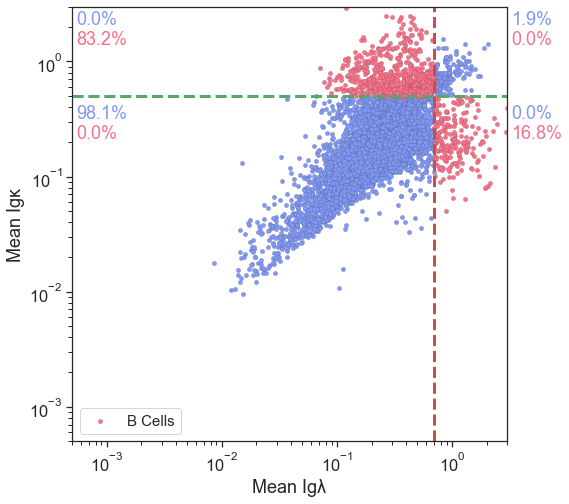

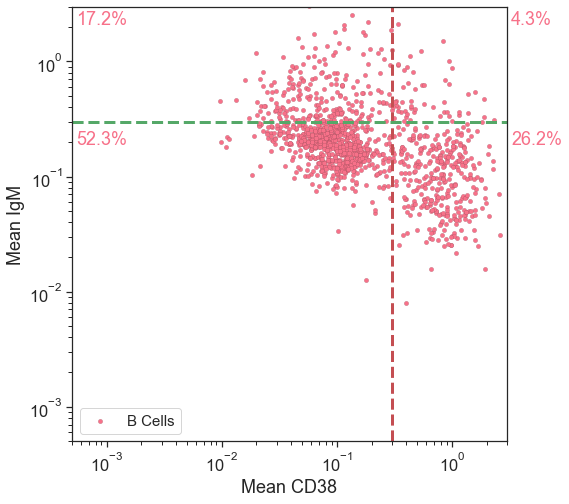

In [30]:
LUMP_B = {
    "Naive B Cells": "B Cells",
    "IgM Memory B Cells": "B Cells",
    "Switched Memory B Cells": "B Cells",
}

plot_gates(bcell_data.replace(LUMP_B), 
           [ "CD3- CD4- CD8α- CD45+", "B Cells"],
           "IgLambda", "IgKappa", remove_first=True, pal=[base[5], base[0]])

plot_gates(bcell_data.replace(LUMP_B), 
           ["B Cells"],
           "CD38", "IgM", pal=[base[0]])

## Heatmap visualization (Figure 7)

In [31]:
# Classes of interest (needs to be in this order for the heatmap)
roi_classes = ["NAWM", "Preactive", "Active Periplaque", "Active Core", "SEL Periplaque", "SEL Edge", "SEL Core"]

In [32]:
# Each key in these maps corresponds to a cell type
# Each sub-key corresponds to a classification of interest
# Values are the assigned class names

# For frequency heatmap
output_class_map = {
    "Myeloid": {
        "1 CD68$^-$": ['Resting Macrophages'],
        "1 CD68$^+$ PLP$^-$": ['Active ND Macrophages'],
        "1 CD68$^+$ PLP$^+$": ['Active D Macrophages'],
        "2 CD68$^-$": ['Resting Microglia'],
        "2 CD68$^+$ PLP$^-$": ['Active ND Microglia'],
        "2 CD68$^+$ PLP$^+$": ['Active D Microglia'],
    },
    "T Cells": {
        "3 All": ['CD8α+ T Cells','Proliferating CD8α+','Activated CD8α+','Prolif. & Activ. CD8α+'],
        "3 NFAT$^+$ Ki67$^-$": ['Activated CD8α+', 'Prolif. & Activ. CD8α+'],
        "3 NFAT$^-$ Ki67$^+$": ['Proliferating CD8α+','Prolif. & Activ. CD8α+'],
        "3 NFAT$^+$ Ki67$^+$": ['Prolif. & Activ. CD8α+'],

        "4 All": ['CD4+ T Cells', 'Proliferating CD4+','Activated CD4+','Prolif. & Activ. CD4+'],
        "4 NFAT$^+$ Ki67$^-$": ['Activated CD4+','Prolif. & Activ. CD4+'],
        "4 NFAT$^-$ Ki67$^+$": ['Proliferating CD4+', 'Prolif. & Activ. CD4+'],
        "4 NFAT$^+$ Ki67$^+$": ['Prolif. & Activ. CD4+'],
        
        "5 All": ["Unclassified T Cells"],
    },
    "B Cells": {
        "6 IgM$^+$ CD38$^-$": ['Naive B Cells'],
        "6 IgM$^+$ CD38$^+$": ['IgM Memory B Cells'],
        "6 IgM$^-$ CD38$^+$": ['Switched Memory B Cells'],
    },
}

# For vessels heatmap
output_class_map_vessels = {
    "Myeloid": {
        "1 CD68$^+$ PLP$^-$ — collagen$^+$": ['Active ND Macrophages'],
        "1 CD68$^+$ PLP$^+$ — collagen$^+$": ['Active D Macrophages'],
    },
    "T Cells": {
        "2 CD8α$^+$ CD4$^-$ — collagen$^+$": ['CD8α+ T Cells','Proliferating CD8α+','Activated CD8α+','Prolif. & Activ. CD8α+'],
        "2 CD8α$^+$ CD4$^-$ NFAT$^+$ Ki67$^+$ — collagen$^+$": ['Prolif. & Activ. CD8α+'],
        "2 CD4$^+$ CD8α$^-$ — collagen$^+$": ['CD4+ T Cells', 'Proliferating CD4+','Activated CD4+','Prolif. & Activ. CD4+'],
        "2 CD4$^+$ CD8α$^-$ NFAT$^+$ Ki67$^+$ — collagen$^+$": ['Prolif. & Activ. CD4+'],
    },
    "B Cells": {
        "3 IgM$^+$ CD38$^-$ — collagen$^+$": ['Naive B Cells'],
        "3 IgM$^-$ CD38$^+$ — collagen$^+$": ['Switched Memory B Cells'],
    },
}

# Relevant datafrrames
output_dfs = {
    "Myeloid": myeloid_data,
    "T Cells": tcell_data,
    "B Cells": bcell_data
}

In [33]:
def subclass_mask(df, *classes):
    """Returns a mask for df representing the union of the specified classes."""
    other = False
    for clss in classes:
        other |= df["Assigned Class"] == clss
    return other

In [34]:
for group, subclasses in output_class_map.items():
    for subclass, classes in subclasses.items():
        df[subclass] = subclass_mask(output_dfs[group], *classes)

for group, subclasses in output_class_map_vessels.items():
    for subclass, classes in subclasses.items():
        df[subclass] = subclass_mask(output_dfs[group], *classes)

In [35]:
# Insert HLA+ CD38+ category manually
t_cell_subclasses = list(output_class_map["T Cells"].keys())
t_cell_subclasses.insert(4, "3 HLA$^+$ CD38$^+$") # CD8a+
t_cell_subclasses.insert(9, "4 HLA$^+$ CD38$^+$") # CD4+

df["3 HLA$^+$ CD38$^+$"] = df["3 All"] & HI["CD38"] & HI["HLA"]
df["4 HLA$^+$ CD38$^+$"] = df["4 All"] & HI["CD38"] & HI["HLA"]

In [36]:
# Same as above for vessels
t_vessel_subclasses = list(output_class_map_vessels["T Cells"].keys())
t_vessel_subclasses.insert(2, "2 CD8α$^+$ CD4$^-$ HLA$^+$ CD38$^+$ — collagen$^+$")
t_vessel_subclasses.insert(5, "2 CD4$^+$ CD8α$^-$ HLA$^+$ CD38$^+$ — collagen$^+$")

df["2 CD8α$^+$ CD4$^-$ HLA$^+$ CD38$^+$ — collagen$^+$"] = df["3 All"] & HI["CD38"] & HI["HLA"]
df["2 CD4$^+$ CD8α$^-$ HLA$^+$ CD38$^+$ — collagen$^+$"] = df["4 All"] & HI["CD38"] & HI["HLA"]

In [37]:
def create_heatmap_data(df, subclasses, method):
    if method == "count":
        dfs = []
        for sc in subclasses:
            dfs.append(df.groupby(["ROI"])[sc].sum())
        tcounts = pd.concat(dfs, axis=1, sort=False).astype(int).transpose()
        return tcounts
    elif method == "vessel":
        dfs_vessel = []
        for sc in subclasses:
            dfs_vessel.append(df[df[sc]].groupby(["ROI"])["Distance to Vessel (um)"].mean().rename(sc))
        tvessel = pd.concat(dfs_vessel, axis=1, sort=False).transpose()
        return tvessel
    else:
        raise ValueError

In [38]:
myeloidcounts = create_heatmap_data(df, tuple(output_class_map["Myeloid"].keys()), "count").reindex(columns=roi_classes)
tcounts = create_heatmap_data(df, t_cell_subclasses, "count").reindex(columns=roi_classes)
bcounts = create_heatmap_data(df, tuple(output_class_map["B Cells"].keys()), "count").reindex(columns=roi_classes)

myeloidvessel = create_heatmap_data(df, tuple(output_class_map_vessels["Myeloid"].keys()), "vessel").reindex(columns=roi_classes)
tvessel = create_heatmap_data(df, t_vessel_subclasses, "vessel").reindex(columns=roi_classes)
bvessel = create_heatmap_data(df, tuple(output_class_map_vessels["B Cells"].keys()), "vessel").reindex(columns=roi_classes)

In [39]:
# Read area data of each ROI as series (used to calculate counts/mm2)
areas = pd.read_csv("data/Areas_mm2.csv", index_col="ROI").reindex(roi_classes).iloc[:,0]

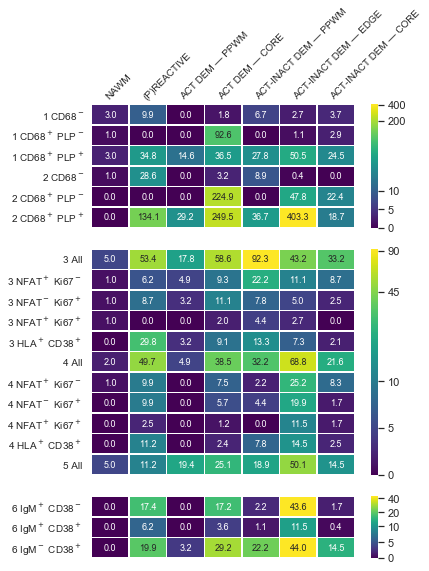

In [40]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1.)
hm_kwargs = {"annot": True, "fmt": ".1f", "cmap": "viridis", "linewidths": 0.5, "cbar": True, "annot_kws":{"size": 9}, "norm": matplotlib.colors.SymLogNorm(10)}

# Make sure height_ratios is set to the number of rows in each group, otherwise aspect ratios will be different for each square.
f, ax = plt.subplots(3, 1, figsize=(6.1,8.1), gridspec_kw={"height_ratios": [len(myeloidcounts), len(tcounts), len(bcounts)]})
sns.heatmap(myeloidcounts / areas, ax=ax[0], **hm_kwargs, cbar_kws={"orientation": "vertical", "format": "%.0f", "ticks": [0,5,10,200,400], "aspect": len(myeloidcounts)*3})
sns.heatmap(tcounts / areas, ax=ax[1], **hm_kwargs, cbar_kws={"orientation": "vertical", "format": "%.0f", "ticks": [0,5,10,45,90], "aspect": len(tcounts)*3}, xticklabels=False)
sns.heatmap(bcounts / areas, ax=ax[2], **hm_kwargs, cbar_kws={"orientation": "vertical", "format": "%.0f", "ticks": [0,5,10,20,40], "aspect": len(bcounts)*3}, xticklabels=False)

# Adjust axes labels, etc. (rename top row of ROI labels to final names)
ax[0].set_xticklabels(["NAWM", "(P)REACTIVE", "ACT DEM — PPWM", "ACT DEM — CORE", "ACT-INACT DEM — PPWM", "ACT-INACT DEM — EDGE", "ACT-INACT DEM — CORE"], 
                      rotation=45, ha="left", rotation_mode="anchor")
ax[0].xaxis.set_ticks_position("top")
ax[0].tick_params(length=0)
for a in ax:
    a.set_xlabel(None)
    a.tick_params(labelsize=10)

# Hack needed to shift the labels on the first subplot to the left to match others
for label in ax[0].yaxis.get_majorticklabels(): label.set_x(-0.015)
f.tight_layout()
f.savefig("figures/heatmap_frequency.png", dpi=300, bbox="tight")

# 1 - Macrophages, 2 - Microglia, 3 - CD8+ T Cells, 4 - CD4+ T Cells, 5 - Unclassified T Cells, 6 - B Cells (add in post)

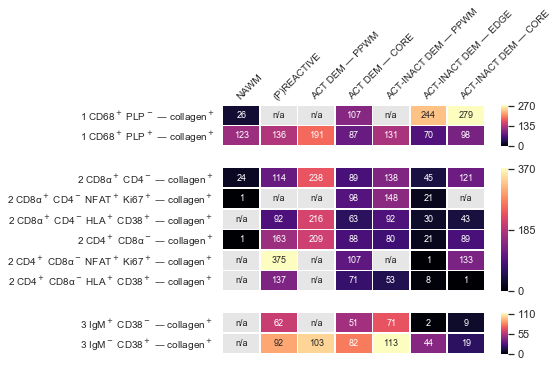

In [41]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1.)

cmap = matplotlib.cm.get_cmap("magma")
cmap.set_under((.9,.9,.9))  # Hack to fill in nan values (-1) as gray.

f, ax = plt.subplots(3, 1, figsize=(7.9,5.26), gridspec_kw={"height_ratios": [len(myeloidvessel), len(tvessel), len(bvessel)]})
hm_kwargs = {"annot": True, "fmt": ".0f", "cmap": cmap, "vmin": 0, "linewidths": 0.5, "cbar": True, "annot_kws": {"size": 9}}
sns.heatmap(myeloidvessel.fillna(-1), ax=ax[0], **hm_kwargs, cbar_kws={"orientation": "vertical", "format": "%.0f", "ticks": [0, 135, 270], "aspect": len(myeloidvessel)*3})
sns.heatmap(tvessel.fillna(-1), ax=ax[1], **hm_kwargs, cbar_kws={"orientation": "vertical", "format": "%.0f", "ticks": [0, 185, 370], "aspect": len(tvessel)*3}, xticklabels=False)
sns.heatmap(bvessel.fillna(-1), ax=ax[2], **hm_kwargs, cbar_kws={"orientation": "vertical", "format": "%.0f", "ticks": [0, 55, 110], "aspect": len(bvessel)*3}, xticklabels=False)

ax[0].set_xticklabels(["NAWM", "(P)REACTIVE", "ACT DEM — PPWM", "ACT DEM — CORE", "ACT-INACT DEM — PPWM", "ACT-INACT DEM — EDGE", "ACT-INACT DEM — CORE"], 
                      rotation=45, ha="left", rotation_mode="anchor")
ax[0].xaxis.set_ticks_position("top")
ax[0].tick_params(length=0)
for a in ax:
    a.set_xlabel(None)
    a.tick_params(labelsize=10)

# Hack needed to shift the labels on the first subplot to the left to match others
for label in ax[0].yaxis.get_majorticklabels(): label.set_x(-0.015)

# Overwrite nan value annotations with n/a
for a in ax:
    for text in a.texts:
        if text.get_text() == "-1": text.set_text("n/a")

f.tight_layout()
f.savefig("figures/heatmap_vesseldistance.png", dpi=300, bbox="tight")

# 1 - Macrophages, 2 - T Cells, 3 - B Cells (add in post)